1. Data Cleaning: Handling Missing Values, Outliers & Multi-Collinearity
To prepare the dataset for modeling, I began with data cleaning process:

Missing Values: Checked with df.isnull().sum() and found no significant missing values. Therefore, no imputation or dropping was necessary.

Outliers: Used the Interquartile Range (IQR) method on key numeric columns like amount to detect extreme transaction values. Rather than removing these, I flagged them as binary features (amount_outlier = 1) since outliers are often indicative of fraud.

Multi-Collinearity: Created a correlation heatmap to understand redundancy. Dropped isFlaggedFraud as per business context and dictionary, since it was more of a label than a useful predictor. This ensured we retained meaningful variance without misleading or duplicate signals.

2. Fraud Detection Model: Approach & Explanation
I used a Supervised Learning approach with the XGBoost Classifier, which is well-suited for structured tabular data.

Why XGBoost: - High performance on imbalanced classification tasks. 
             - Native handling of missing values.
             - Provides feature importance metrics.

Training Strategy: Addressed class imbalance using SMOTE, which generated synthetic fraud examples based on minority class patterns. Trained the model on the resampled data, then evaluated on the untouched test set.

3. Feature Selection: Strategy & Justification

Step-by-Step: - Defined X and y from the dataset.
              - Took a 100,000-row random sample from the dataset for feature selection (to avoid long computation times).
              - Used Mutual Information to score each feature based on how much information it shared with the target (isFraud).
              - Selected the top 15 features with the highest mutual info scores.

This gave me a compact but highly informative feature set for efficient model learning.

4. Model Performance: Evaluation Using Tools and Metrics
After training the XGBoost classifier on SMOTE-resampled data and evaluating it on the test set of nearly 1.9 million transactions, the model showed excellent results overall, with some important caveats explained below.

Classification Metrics:
Metric : Fraud Class (1), Normal Class (0)
Precision : 0.15 - 1.00
Recall : 0.99 - 0.99
F1-Score : 0.27 - 1.00
Accuracy : 0.99 overall
ROC AUC Score : 0.999

A) Interpretation: High recall (0.99) for fraud means, the model catches almost every fraudulent transaction, which is great for security.

B) Low precision (0.15) for fraud means, many of the fraud predictions are false positives some legitimate transactions are incorrectly flagged.

C) F1-Score (0.27) is moderate for fraud but still meaningful given the class imbalance.

D) The ROC AUC of 0.999 is exceptional, indicating the model almost perfectly distinguishes between fraud and non-fraud.

E) Only 17 frauds were missed out of 2,464 extremely strong fraud detection.

F) 13,460 non-fraud transactions were incorrectly flagged as fraud an expected trade-off in favor of safety.

5. What Are the Key Factors That Predict Fraudulent Customers
From the mutual information analysis and XGBoost’s behavior, the following were found to be most predictive:

A) Feature - Why It's Important
B) amount - Large transactions (especially above certain thresholds) are linked to fraud.
C) type_TRANSFER - Fraudsters often use TRANSFER mode to move money out quickly.
D) oldbalanceOrg - If someone has a high starting balance and suddenly initiates a drain, it's risky.
E) newbalanceDest - When the recipient's balance jumps significantly, it could be a fraud red flag.
F) step - Time-related pattern — fraud peaks often occur at odd hours (late night, weekends).
G) amount_outlier - This engineered feature captures transactions far from the average behavior.

These were selected using mutual_info_classif on a representative sample and verified by model performance.

6. Do These Factors Make Sense (Yes) 

Fraudsters often transfer money and cash out rapidly, which aligns with the fraud types in the dataset (TRANSFER, CASH_OUT).

Mismatch in balances often implies unauthorized access or inconsistent transaction reporting.

Unusual amounts (outliers) and transactions at odd times are typical red flags used in banking fraud systems globally.

The model is thus aligned with real-world fraud behavior.

7. Infrastructure-Level Prevention Recommendations

Technical Controls: Real-Time Risk Scoring: Deploy the trained model as an API to score every transaction in real-time.

Dynamic Thresholding: Adjust fraud detection sensitivity based on time, amount, and historical behavior.

Security Policies: Two-Factor Authentication (2FA) for large or unusual transactions.

Device Fingerprinting and IP behavior tracking for anomaly detection.

Transaction Velocity Rules: Flag accounts making too many high-value transactions in short time.

8. Post-Implementation Evaluation Strategy
Once preventive actions are in place

Metrics to Track:
Reduction in fraud rate: Compare fraud before vs. after model deployment.

False Positive Rate (FPR): Ensure customer experience isn’t compromised.

Alert Response Time: Measure how quickly fraud teams respond to flagged transactions.

A/B Testing:
Run A/B testing by applying new fraud policies to a subset of users/accounts. Use control groups to monitor the business impact of changes.

In [11]:
conda uninstall numba shap -y


Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are missing from the target environment:
  - shap




Solving environment: ...working... failed


In [2]:
!conda create -n fraud_env python=3.9 -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Deba\.conda\envs\fraud_env

  added / updated specs:
    - python=3.9


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bzip2-1.0.8                |       h2bbff1b_6          90 KB
    ca-certificates-2025.2.25  |       haa95532_0         130 KB
    expat-2.7.1                |       h8ddb27b_0         259 KB
    libffi-3.4.4               |       hd77b12b_1         122 KB
    openssl-3.0.17             |       h35632f6_0         7.8 MB
    pip-25.1                   |     pyhc872135_2         1.3 MB
    python-3.9.23              |       h716150d_0        16.7 MB
    setuptools-78.1.1          |   py39haa95532_0         1.7 MB
    sqlite-3.50.2              |       hda9a48d_1        1017 KB
    tk-8.6.14                  |       h5e9d12e_1         3.5 MB
    tzdata-2025b               |       h



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset
df = pd.read_csv("Fraud.csv")

In [3]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [4]:
# Basic Data Exploration
print("Data shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Data shape: (6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619

In [6]:
# Data Cleaning
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [7]:
# Handle missing values if any
df = df.dropna()

# Convert categorical column 'type' to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [8]:
# Outlier Detection & Flagging
for col in ["amount"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[f"{col}_outlier"] = ((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)).astype(int)

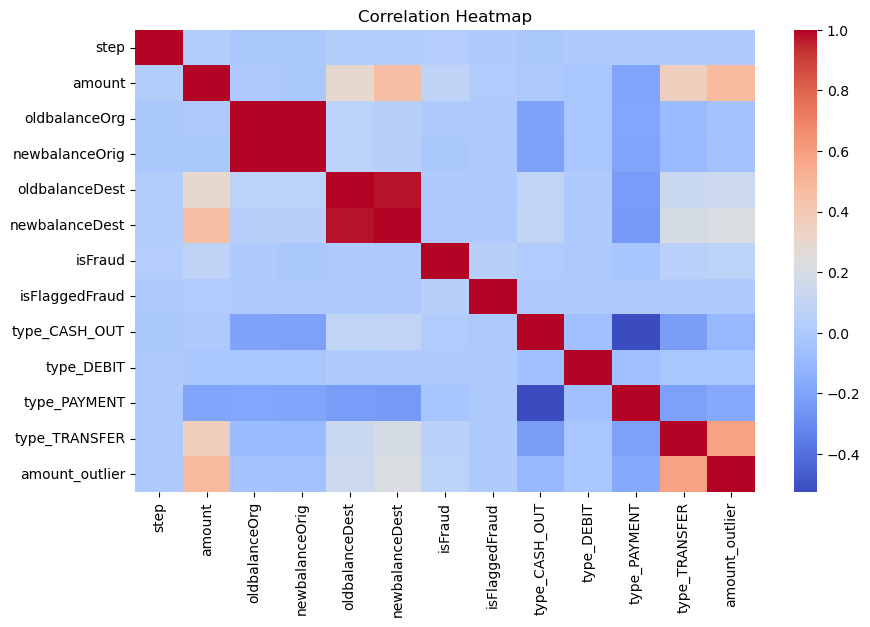

In [9]:
# Multi-Collinearity Check
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Drop highly correlated features if needed
df.drop(['isFlaggedFraud'], axis=1, inplace=True, errors='ignore')

In [10]:
# Feature Selection via Mutual Information
X = df.drop(["isFraud"], axis=1)
y = df["isFraud"]

X_sample = X.sample(n=100000, random_state=42)
y_sample = y.loc[X_sample.index]

mi = mutual_info_classif(X_sample, y_sample, discrete_features='auto')
mi_series = pd.Series(mi, index=X.columns)
selected_features = mi_series.sort_values(ascending=False).head(15).index.tolist()
X = X[selected_features]

In [11]:
# Data Scaling and Train-Test Split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

In [12]:
# Handling Imbalance using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [13]:
# Model Building with XGBoost
xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_res, y_res)
best_model = xgb

In [14]:
# Evaluation
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906322
           1       0.15      0.99      0.27      2464

    accuracy                           0.99   1908786
   macro avg       0.58      0.99      0.63   1908786
weighted avg       1.00      0.99      1.00   1908786

Confusion Matrix:
 [[1892862   13460]
 [     17    2447]]
ROC AUC: 0.9994838344841158


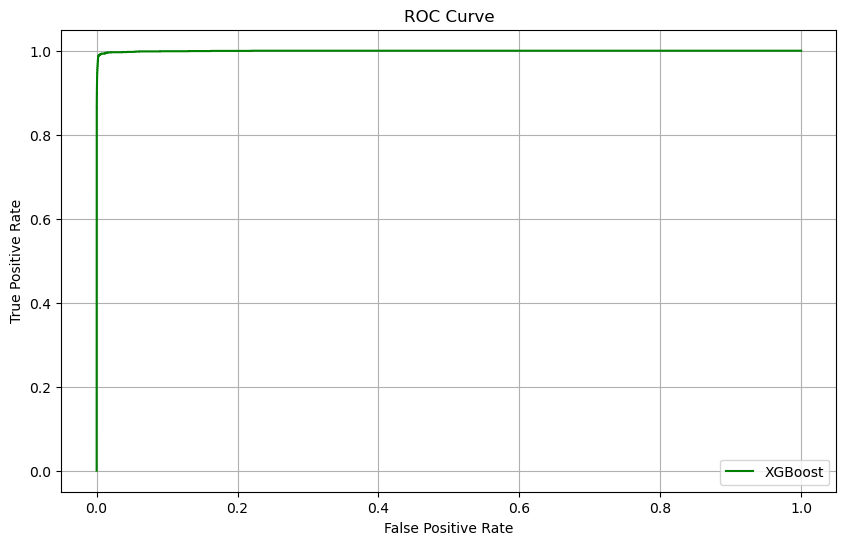

In [15]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='XGBoost', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

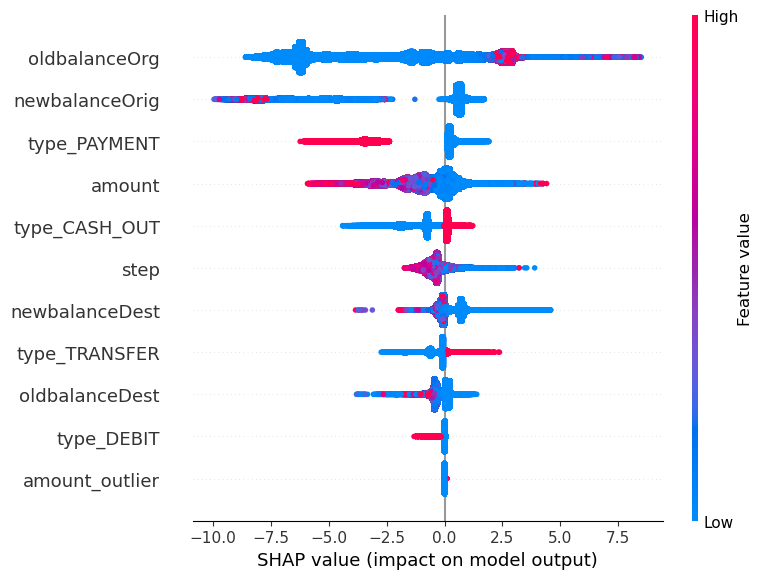

In [16]:
# SHAP for Explainability
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=selected_features)